In [1]:
import os
os.environ['JAX_PLATFORM_NAME'] = 'cpu'
from inference.spatial_compartmental.viz import  posterior_comparison, post_prediction_comparison
import jax
#jax.config.update("jax_enable_x64", True) #64 bit precision calcs
#jax.config.update('jax_platform_name', 'cpu')
import jax.numpy as jnp
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import gc
from abm.spatial_compartmental.si import get_abm
from abm.spatial_compartmental.utils import Neighbourhood, calc_start_n_initial
import pickle
import matplotlib.ticker as ticker
from checkpointing import CheckPointer
from flax import nnx
from functools import partial
import numpyro
import numpyro.distributions as dist

/home/tim/Documents/thesis/dgs4abm/.venv/lib64/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from matplotlib.lines import Line2D
from matplotlib.collections import PathCollection
from matplotlib.container import BarContainer
from matplotlib.patches import Rectangle
import matplotlib.patches as mpatches

def get_color_by_label(ax, label):
    """
    Finds a plotted element on the axes by its label and returns its color.

    Args:
        ax (matplotlib.axes.Axes): The axes object containing the plot.
        label (str): The label of the element to find.

    Returns:
        tuple or str or None: The color (often RGBA tuple) of the element,
                               or None if no element with that label is found.
    """
    # Check lines (plot)
    for line in ax.lines:
        if line.get_label() == label:
            return line.get_color() # Returns color format used (e.g., 'red', '#FF0000', (1,0,0,1))

    # Check containers (common for bar plots)
    for container in ax.containers:
        if isinstance(container, BarContainer) and container.get_label() == label:
            # Get color from the first patch in the container
            if container.patches:
                return container.patches[0].get_facecolor() # Returns RGBA tuple

    # Check collections (scatter)
    for collection in ax.collections:
        if collection.get_label() == label:
            # Facecolor is often an array, even for single color. Take the first.
            colors = collection.get_facecolor()
            if colors.size > 0:
                return colors[0] # Returns RGBA tuple array, take first row
            else: # May happen if color is 'none' or similar
                 edge_colors = collection.get_edgecolor()
                 if edge_colors.size > 0:
                     return edge_colors[0]


    # Check individual patches (less common for labeled elements but possible)
    for patch in ax.patches:
         # Only consider patches that are direct children (not part of a container already checked)
        if isinstance(patch, Rectangle) and patch.get_label() == label:
             # Check if it belongs to a container; if so, we likely handled it above
             if patch.get_container() is None or patch.get_container().get_label() != label:
                  return patch.get_facecolor()

    # Label not found
    print(f"Warning: No element found with label '{label}'")
    return None

## Surrogate Variability vs ABM

In [3]:
abm = get_abm(Neighbourhood.DIAGONAL,vmap=True)

In [ ]:
g40_s10_output_dir = "inference_outputs/2025-04-24/22-36-28/"

with open(f"{g40_s10_output_dir}/prior_predictions.npy", "rb") as f:
    prior_predictions = jax.device_get(jnp.load(f, allow_pickle=True).item())
with open(f"{g40_s10_output_dir}/abm_posterior.npy", "rb") as f:
    abm_posterior = jax.device_get(jnp.load(f, allow_pickle=True).item())
with open(f"{g40_s10_output_dir}/surrogates_posterior.npy", "rb") as f:
    surrogates_posterior = jax.device_get(jnp.load(f, allow_pickle=True).item())
with open(f"{g40_s10_output_dir}/data.npy", "rb") as f:
    data = jax.device_get(jnp.load(f, allow_pickle=True).item())

In [21]:
priorcvae = CheckPointer.load('trained_models/2025-04-24/14-13-07')[0]
nnx.display(priorcvae)

/home/tim/Documents/thesis/dgs4abm/.venv/lib64/python3.12/site-packages/orbax/checkpoint/_src/serialization/type_handlers.py:1175: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


In [ ]:
mcmlp = CheckPointer.load('trained_models/2025-04-24/14-06-31')[0]
nnx.display(mcmlp)

/home/tim/Documents/thesis/dgs4abm/.venv/lib64/python3.12/site-packages/orbax/checkpoint/_src/serialization/type_handlers.py:1175: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


In [73]:
def preds_plot(ax, I_list, colour,alpha):
    line_data = (jnp.mean(I_list, axis=0)
    )
    quantiles_I_2pt5 = jnp.quantile(I_list, 0.025, axis=0)
    quantiles_I_97pt5 = jnp.quantile(I_list, 0.975, axis=0)
    ax.plot(range(1,11), line_data, color=colour)
    ax.fill_between(
        range(1,11),
        quantiles_I_2pt5,
        quantiles_I_97pt5,
        color=colour,
        alpha=alpha,
    )

<>:19: SyntaxWarning: invalid escape sequence '\m'
<>:19: SyntaxWarning: invalid escape sequence '\m'
/tmp/ipykernel_50871/1107557741.py:19: SyntaxWarning: invalid escape sequence '\m'
  axarr[idx].set_xlabel(f"$p_{{\mathrm{{infect}}}}$ = {p_inf} and Initial infection = {calc_start_n_initial(prop_initial, 10)}")
/home/tim/Documents/thesis/dgs4abm/.venv/lib64/python3.12/site-packages/orbax/checkpoint/_src/serialization/type_handlers.py:1175: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


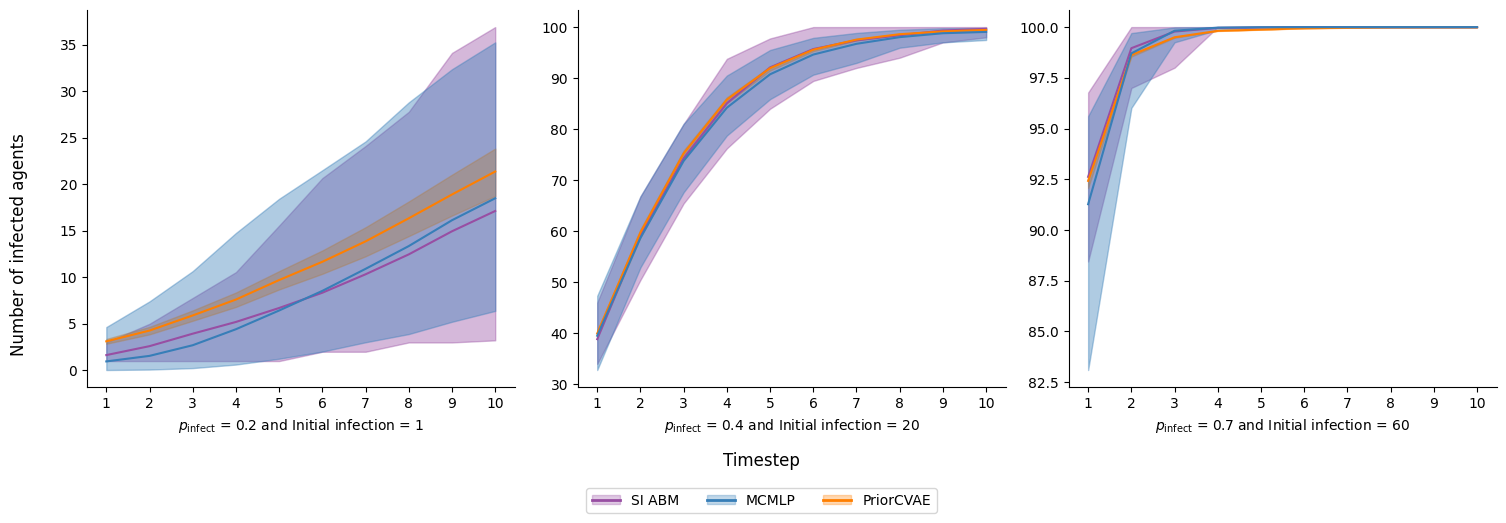

In [145]:
fig, axarr = plt.subplots(1,3, figsize=(15,5))

priorcvae = CheckPointer.load('trained_models/2025-04-24/14-11-34')[0]
mcmlp = CheckPointer.load('trained_models/2025-04-24/14-06-31')[0]

for idx, (p_inf, prop_initial) in enumerate(zip([0.2,0.4,0.7],[0.01,0.2,0.6])):
    axarr[idx].spines[["right", "top"]].set_visible(False)
    axarr[idx].xaxis.set_major_locator(ticker.MultipleLocator(1))
    axarr[idx].set_xticks(range(1, int(10) + 1))
    _, _, abm_I_list = abm(
            jax.random.split(jax.random.key(42),50),
            10,
            10,
            p_inf,
            calc_start_n_initial(prop_initial, 10),
        )
    abm_I_list = abm_I_list[:,1:]
    preds_plot(axarr[idx], abm_I_list, '#984ea3',alpha=0.4)
    axarr[idx].set_xlabel(f"$p_{{\mathrm{{infect}}}}$ = {p_inf} and Initial infection = {calc_start_n_initial(prop_initial, 10)}")

    priorcvae_I_list = priorcvae.generate_decoder_samples(key=jax.random.key(42),   num_samples=50,
             c=jnp.broadcast_to(
             jnp.array([p_inf, prop_initial]),
                 (50, 2),
             ),)
    priorcvae_I_list = priorcvae_I_list[:,1:]*(10**2)
    preds_plot(axarr[idx], priorcvae_I_list, '#ff7f00', alpha=0.4)


    mcmlp_I_list = partial(nnx.vmap(lambda module, x, key: module(x, key),
                                        in_axes=(None, None, 0),
                                        out_axes=0,
                                    ),mcmlp)(jnp.array([p_inf,prop_initial]),jax.random.split(jax.random.key(42),50))
    mcmlp_I_list = mcmlp_I_list[:,1:]*(10**2)
    preds_plot(axarr[idx], mcmlp_I_list, '#377eb8', alpha=0.4)
del priorcvae
del mcmlp

fig.supylabel('Number of infected agents',fontsize=12,x=-0.001)
fig.supxlabel('Timestep',fontsize=12,y=0.05)
legend_handles=[]
legend_labels=['SI ABM', 'MCMLP','PriorCVAE', ]
for colour in ['#984ea3', '#377eb8', '#ff7f00']:
    legend_handles.append((Line2D([0],[0],color=colour,
                           linestyle='-', linewidth=2),mpatches.Patch(color=colour,alpha=0.3)))
fig.legend(handles=legend_handles, labels=legend_labels,loc='lower center', bbox_to_anchor=(0.5, -0.05), ncol=len(legend_labels))

plt.tight_layout(rect=[0, 0.025, 1, 1],h_pad=1,w_pad=1)
fig.savefig('../05_25_viz/si_surrogate_g10s10_realisation_stoch.pdf',bbox_inches='tight')


## Parameter Uncertainty

<>:42: SyntaxWarning: invalid escape sequence '\m'
<>:57: SyntaxWarning: invalid escape sequence '\m'
<>:42: SyntaxWarning: invalid escape sequence '\m'
<>:57: SyntaxWarning: invalid escape sequence '\m'
/tmp/ipykernel_21924/3802424273.py:42: SyntaxWarning: invalid escape sequence '\m'
  x=abm_params[0], color="red", linestyle="--", label=f"True $p_{{\mathrm{{infect}}}}$"
/tmp/ipykernel_21924/3802424273.py:57: SyntaxWarning: invalid escape sequence '\m'
  legend_labels=['Prior','SI ABM Posterior', 'MCMLP Posterior','PriorCVAE Posterior',"True $p_{{\mathrm{{infect}}}}$" ]


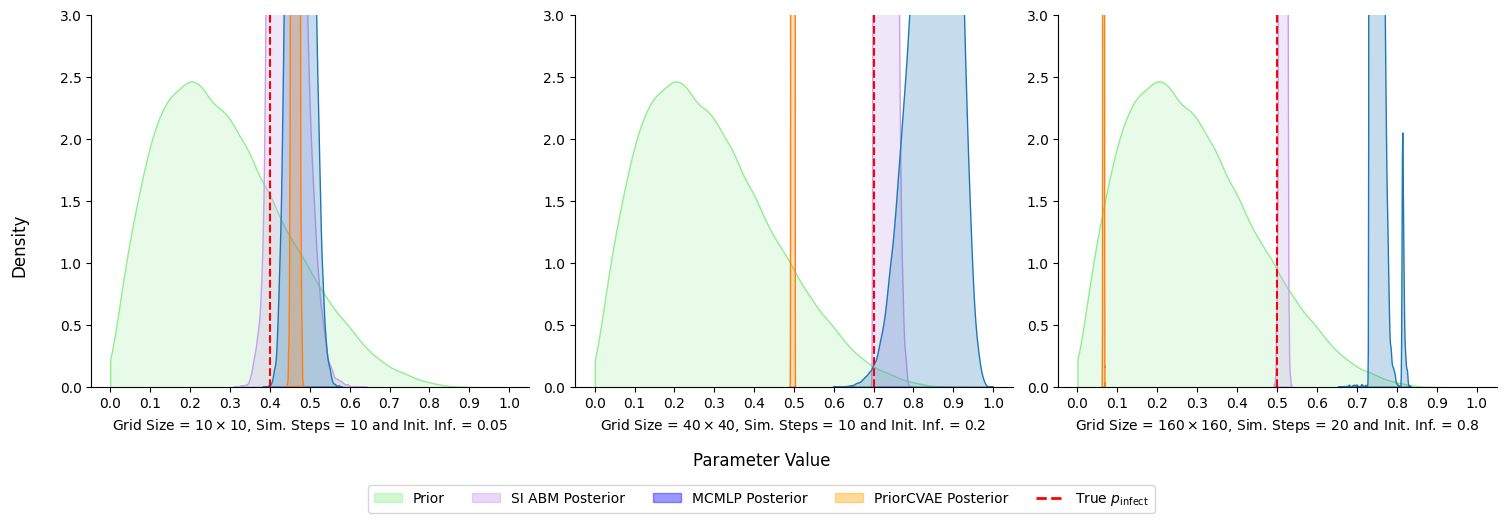

: 

In [ ]:
fig, axarr = plt.subplots(1,3, figsize=(15,5))
grid_sizes = [r"$10\times10$", r"$40\times40$", r"$160\times160$"]
sim_steps =[r'$10$', r'$10$', r'$20$']
init_inf = [r'$0.05$', r'0.2', r'0.8']

for idx,(res_dir, abm_params) in enumerate(zip(["inference_outputs/2025-04-25/21-34-38/", 
                                                "inference_outputs/2025-04-24/22-36-28/",
                                                "inference_outputs/2025-04-25/14-31-48/" ],[(0.4,0.05), (0.7,0.2), (0.5,0.8)])):
    with open(f"{res_dir}/prior_predictions.npy", "rb") as f:
        prior_predictions = jax.device_get(jnp.load(f, allow_pickle=True).item())
    with open(f"{res_dir}/abm_posterior.npy", "rb") as f:
        abm_posterior = jax.device_get(jnp.load(f, allow_pickle=True).item())
    with open(f"{res_dir}/surrogates_posterior.npy", "rb") as f:
        surrogates_posterior = jax.device_get(jnp.load(f, allow_pickle=True).item())



    sns.kdeplot(
            prior_predictions['p_infect'],
            fill=True,
            color="lightgreen",
            ax=axarr[idx],
            alpha=0.2,
            label="Prior",
            clip=(0, None),
        )
    sns.kdeplot(
        abm_posterior[abm_params]["posterior_samples"]['p_infect'],
        fill=True,
        color="xkcd:lavender",
        ax=axarr[idx],
        label="ABM Posterior",
    )
    for surrogate_name, surrogate_samples in surrogates_posterior.items():
        sns.kdeplot(
            surrogate_samples[abm_params]["posterior_samples"]["p_infect"],
            fill=True,
            ax=axarr[idx],
            label=f"{surrogate_name} Posterior",
        )
    axarr[idx].axvline(
        x=abm_params[0], color="red", linestyle="--", label=f"True $p_{{\mathrm{{infect}}}}$"
    )


    axarr[idx].set_xlim(None, 1.05)
    axarr[idx].xaxis.set_major_locator(ticker.MultipleLocator(0.1))
    axarr[idx].set_ylim(0, 3)
    axarr[idx].set_ylabel("")
    axarr[idx].spines[["right", "top"]].set_visible(False)
    axarr[idx].set_xlabel(f'Grid Size = {grid_sizes[idx]}, Sim. Steps = {sim_steps[idx]} and Init. Inf. = {init_inf[idx]} ')

fig.supxlabel("Parameter Value",fontsize=12, y=0.05)
fig.supylabel("Density",fontsize=12,x=-0.001)

legend_handles=[]
legend_labels=['Prior','SI ABM Posterior', 'MCMLP Posterior','PriorCVAE Posterior',"True $p_{{\mathrm{{infect}}}}$" ]
for colour in ['lightgreen', 'xkcd:lavender', 'blue', 'orange']:
    legend_handles.append(mpatches.Patch(color=colour,alpha=0.4))
legend_handles.append(Line2D([0],[0],color='red',
                           linestyle='--', linewidth=2))
fig.legend(handles=legend_handles, labels=legend_labels,loc='lower center', bbox_to_anchor=(0.5, -0.05), ncol=len(legend_labels))


plt.tight_layout(rect=[0, 0.025, 1, 1],h_pad=1,w_pad=1)
fig.savefig('../05_25_viz/si_surrogate_parameter_uncertainty.pdf',bbox_inches='tight')
